### **1. Introduction & Learning Objectives**

Deep learning models that we’ve explored so far — from perceptrons to convolutional and recurrent architectures — have primarily been **predictive** in nature. Their objective was to take an input and *predict* an output label, such as whether an image shows a cat or a dog, or whether a person’s heart condition indicates disease.  

In this notebook, we begin a new phase of our deep learning journey: we shift from *predictive* to **reconstructive** modeling. Instead of predicting an external label, reconstructive models learn to **represent and regenerate** their input data. These are known as **generative models**, and the simplest of them is the **autoencoder**.

> Autoencoders are neural networks designed to learn efficient representations of data — often called *latent features* — by compressing the input into a lower-dimensional form and then reconstructing it back as closely as possible.

This shift represents a key conceptual turning point in our course. Predictive models focus on *classification* and *decision boundaries*, while generative models focus on *understanding* and *reconstructing structure* in the data. As we move toward models that can generate, imagine, or synthesize new data, we must first grasp how machines can *learn to represent* what they see.

**Learning Objectives**

By the end of this notebook, we will be able to:

- Understand the structure and organization of the **FER2013 dataset**, which contains facial images across seven emotion categories.  
- Learn the architecture and operation of a **basic autoencoder**, including its encoder and decoder components.  
- Visualize how an autoencoder **compresses and reconstructs** facial expressions, gaining intuition into how emotional features are encoded in latent space.  

> We will also connect these ideas back to what we’ve learned in earlier projects — such as how neural networks extract *features* (P4–P6) and how *latent representations* capture underlying structure in complex data (P7–P8). This will help us see autoencoders as a natural continuation of those intuitions, but in a self-supervised setting where labels are no longer required.

In the next section, we will explore the **FER2013 dataset** — understand its dimensions, class distribution, and how we can visualize facial expressions to gain intuition before building our autoencoder.

---

### **2. Understanding the FER2013 Dataset**

Before we can train an autoencoder, we must understand the data it will learn to reconstruct. In this project, we will work with the **FER2013 dataset** — a widely used benchmark for facial emotion recognition.  

The dataset contains grayscale facial images of size **48×48 pixels**, each labeled with one of seven basic emotions:

> **Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral**

However, for our purposes, we will not use the labels during training because the autoencoder learns in a **self-supervised** manner — it tries to reconstruct its input image rather than classify it. Still, knowing the dataset’s structure and emotional diversity helps us interpret the features it learns.

**Dataset Overview**

The original FER2013 dataset consists of over **35,000 facial images**, divided into training, validation, and test splits. Each image is centered on a face with varying expressions, lighting, and orientations.  

To make experimentation more accessible (especially when training on CPU), we will use a **downsampled and balanced version** of this dataset — `fer2013_small.npz` — which we prepared earlier. This smaller dataset maintains a similar emotional diversity but reduces redundancy for faster model training.

> The downsampled dataset contains approximately **9,000 images** (around 1,280 per emotion class), resized to **48×48** grayscale format and normalized so that pixel intensities lie in the range $[0, 1]$.

**Why FER2013 for Autoencoders?**

We choose FER2013 because it provides a rich variety of **human facial expressions**, making it ideal for learning latent representations of emotions. Even though we will not use the emotion labels during training, these variations in expression provide a strong basis for the autoencoder to learn how to **capture structure, symmetry, and key facial features** (like eyes, mouth, and eyebrows).  

Autoencoders will naturally try to reconstruct the “average” facial structure while still preserving emotion-specific traits in their latent representations. This allows us to visualize how the model **encodes emotional cues** without ever being told what “happy” or “sad” means.

**Loading and Inspecting the Dataset**

We will now load our working dataset, `fer2013_small.npz`, which contains two arrays:

- `X`: facial images of shape `(N, 48, 48)`, with normalized pixel values in $[0, 1]$  
- `y`: integer emotion labels $\in \{0, \dots, 6\}$ following the FER2013 convention  

Even though we will not use `y` during training, it remains useful for visualizing examples by class later.

> Let’s begin by loading the dataset and displaying a few sample images from different emotion categories to gain an intuitive understanding of what the model will see.

---

### **3. Visualizing the Dataset**

Before we train any model, it’s essential that we first *see* and *understand* our data.  
Visual inspection allows us to intuitively grasp what the model will learn from — the kinds of variations, textures, and patterns that exist in our dataset.

In this project, we will explore the **FER2013 subset** that we prepared earlier (`fer2013_small.npz`). This dataset contains grayscale facial images of size **48×48**, drawn from seven emotion categories:  

> **Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral**

Even though our autoencoder will learn without labels (self-supervised), we’ll use these categories to visualize how expressions vary across the dataset.  

**Load and Inspect the Dataset**

Let’s begin by loading the dataset and checking the shapes of the input array `X` and label array `y`.

In [33]:
import numpy as np

# Load the downsampled dataset
data = np.load("fer2013_small.npz")
X, y = data["X"], data["y"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Pixel value range:", X.min(), "to", X.max())

Shape of X: (8257, 48, 48)
Shape of y: (8257,)
Pixel value range: 0.0 to 1.0


Here:
- X contains grayscale facial images of shape (N, 48, 48) where $N \approx 9000$
- y contains integer emotion labels $\in {0, 1, \dots, 6}$
- Each image has been normalized so that its pixel values lie in $[0, 1]$

**Visualizing Sample Images**

Let’s look at a few sample faces from each emotion class.
This helps us appreciate the diversity in expressions, orientations, and lighting — the kinds of variations the model must learn to represent efficiently.

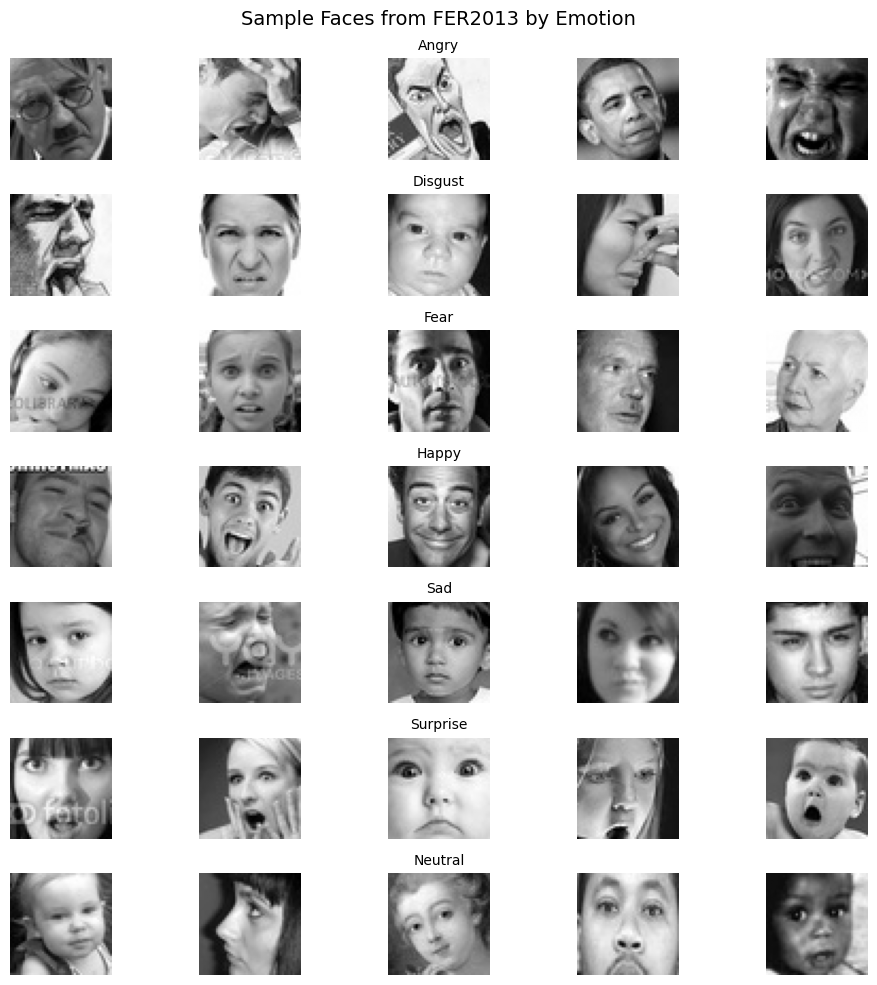

In [3]:
import matplotlib.pyplot as plt

# Define emotion labels for readability
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(10, 10))

for i, label in enumerate(range(7)):
    # Pick 5 random samples from each emotion
    idx = np.where(y == label)[0]
    sample_idx = np.random.choice(idx, size=5, replace=False)

    for j, img_idx in enumerate(sample_idx):
        plt.subplot(7, 5, i * 5 + j + 1)
        plt.imshow(X[img_idx], cmap="gray")
        if j == 2:
            plt.title(emotions[label], fontsize=10)
        plt.axis("off")

plt.suptitle("Sample Faces from FER2013 by Emotion", fontsize=14)
plt.tight_layout()
plt.show()

>As we can see, the dataset contains a wide range of facial variations — from subtle smiles to intense expressions.</br>
>Such diversity makes FER2013 an excellent testbed for learning latent representations of emotions.

**Class Distribution**

Next, let’s check if our downsampled dataset remains balanced across the seven emotion categories.

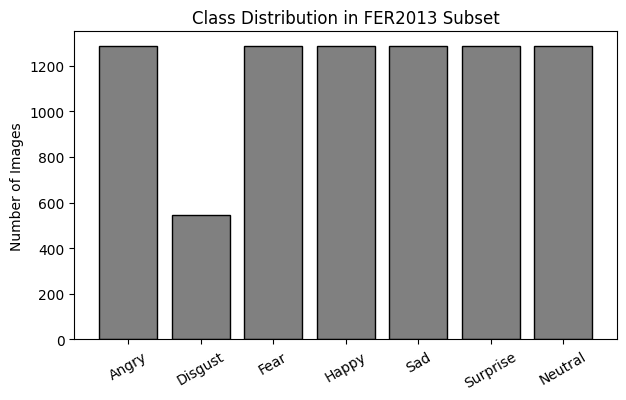

{'Angry': 1285, 'Disgust': 547, 'Fear': 1285, 'Happy': 1285, 'Sad': 1285, 'Surprise': 1285, 'Neutral': 1285}


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class counts
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(7, 4))
plt.bar(emotions, counts, color="gray", edgecolor="black")
plt.title("Class Distribution in FER2013 Subset")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)
plt.show()

print(dict(zip(emotions, counts)))


In our prepared subset, each emotion has roughly 1,200–1,300 samples, ensuring that no single expression dominates the learning process.

**Reflection**

By visualizing the dataset, we gain a sense of both structure and challenge.
Although all images share a consistent size and grayscale format, the emotional expressions, lighting, and pose vary widely.

>This variability is exactly what will encourage our autoencoder to learn generalized and compact representations — capturing what is common across all faces while still retaining the essence of emotional difference.

In the next section, we’ll build our conceptual understanding of autoencoders and see how they can learn such efficient internal representations without needing labels.

---

### **4. Conceptual Understanding of Autoencoders**

So far, we have explored and visualized our dataset — a collection of faces showing different emotional expressions.  
Now, instead of classifying these faces into emotion categories, we will take a new approach: **teaching the model to reconstruct the same image it sees**.

This forms the foundation of a family of models known as **autoencoders**.

**What is an Autoencoder?**

An **autoencoder** is a type of **neural network** designed to learn efficient representations of data in an *unsupervised* way.  
Its goal is not to predict a label, but to **reproduce its input** as closely as possible.

Conceptually, the autoencoder consists of three main parts:

> **Encoder → Latent Space → Decoder**

Let’s unpack what each part does:

- **Encoder:**  
  This part compresses the input image $x$ into a smaller, more compact form.  
  It extracts key patterns — such as eye position, mouth curvature, and general face shape — and discards unnecessary pixel-level details.

- **Latent Space (or Bottleneck):**  
  This is the “compressed summary” of the input, often represented as a low-dimensional vector $z$.  
  Here, the model captures **essential features** that describe the data efficiently.  
  Each point in this latent space encodes meaningful characteristics of the original image.

- **Decoder:**  
  This part attempts to reconstruct the original image $\hat{x}$ from the latent representation $z$.  
  The decoder learns to reverse the compression — like expanding the summary back into the full image.

**Schematic Representation**

We can visualize an autoencoder in a simple schematic form:



```text
       Input (48×48 face)
               │
               ▼
           [ Encoder ]
     (reduces dimensionality)
               │
               ▼
    [ Latent Representation ]
               │
               ▼
           [ Decoder ]
      (reconstructs the input)
               │
               ▼
    Output (Reconstructed face)
```


This structure is symmetrical — what the encoder compresses, the decoder tries to expand back.

**The Learning Objective**

To train an autoencoder, we compare the reconstructed image $\hat{x}$ with the original input $x$.  
The goal is to make them as close as possible.  

This is done using a **reconstruction loss**, often the **Mean Squared Error (MSE)**:

$$
L = \frac{1}{N}\sum_{i=1}^{N} (x_i - \hat{x}_i)^2
$$

Here:
- $x_i$ = original input image  
- $\hat{x}_i$ = reconstructed image produced by the network  
- $N$ = number of training samples  

By minimizing this loss, the model learns to **compress and reconstruct** data in a way that preserves its most important structures.

**Intuitive Analogy**

To build an intuition, imagine the autoencoder as an artist who:

> **“Looks at a detailed photograph of a face, sketches it quickly from memory (encoding),**  
> **and then redraws it as faithfully as possible later (decoding).”**

The quality of the sketch depends on how well the artist captures the *essence* of the face rather than the fine details.  
Similarly, a good autoencoder focuses on **core features** — symmetry, contrast, emotion cues — while ignoring noise or redundant information.

**Why Autoencoders Matter**

Autoencoders help us:
- **Discover patterns** in unlabeled data.  
- **Compress data** efficiently while preserving meaningful structure.  
- **Visualize latent spaces**, where similar expressions or faces may cluster together.  

They form the foundation for many powerful generative models like **Variational Autoencoders (VAEs)** and **Generative Adversarial Networks (GANs)**, which we will explore in upcoming projects.

> In the next section, we will implement our first **fully connected autoencoder** in PyTorch and train it on the FER2013 subset to see how well it can reconstruct faces from their compressed representations.

---

### **5. Building a Basic Autoencoder in PyTorch**

We will now translate our conceptual autoencoder into a simple, fully connected PyTorch model.  
Because each face image is grayscale with size **48×48**, we first **flatten** it into a vector of length **2,304**. The encoder compresses this vector into a **128-dimensional latent representation**, and the decoder expands it back to **2,304** values. Finally, we **reshape** the output vector to recover the original **48×48** image.

> We use `Sigmoid` at the output so pixel predictions lie in the range $[0, 1]$, matching our normalized inputs.

**Model Definition**

In [22]:
import torch
import torch.nn as nn

# For reproducibility
torch.manual_seed(42)

# Flattened input size for 48×48 grayscale images
INPUT_DIM = 48 * 48         # 2304
LATENT_DIM = 128

class FC_Autoencoder(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder: 2304 -> 512 -> 128
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
            nn.ReLU(inplace=True),
        )
        # Decoder: 128 -> 512 -> 2304
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # constrain output to [0, 1]
        )

    def forward(self, x):
        """
        x: (N, 1, 48, 48) or (N, 48, 48)
        returns: reconstruction with same shape as input
        """
        # Ensure shape is (N, 48, 48)
        if x.dim() == 4:        # (N, 1, 48, 48)
            x = x.squeeze(1)
        # Flatten to (N, 2304)
        n = x.size(0)
        x_flat = x.view(n, -1)
        # Encode -> Decode
        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)
        # Reshape back to (N, 48, 48)
        x_hat = x_hat_flat.view(n, 48, 48)
        # Add channel dim back to be consistent with PyTorch image conventions
        x_hat = x_hat.unsqueeze(1)  # (N, 1, 48, 48)
        return x_hat


**Instantiate the Model and Verify Shapes**

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FC_Autoencoder().to(device)

# Sanity check with a dummy batch
with torch.no_grad():
    dummy = torch.rand(8, 1, 48, 48, device=device)  # batch of 8 images in [0, 1]
    out = model(dummy)
    print("Input shape :", tuple(dummy.shape))
    print("Output shape:", tuple(out.shape))


Input shape : (8, 1, 48, 48)
Output shape: (8, 1, 48, 48)


>We expect to see Input shape : (8, 1, 48, 48) and Output shape: (8, 1, 48, 48).</br>
This confirms our flatten → encode → decode → reshape pipeline is consistent.

**Lightweight Model Summary**

In [24]:
def count_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(model)  # architecture overview
print("Trainable parameters:", count_params(model))


FC_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=2304, bias=True)
    (3): Sigmoid()
  )
)
Trainable parameters: 2493824


- The printed architecture helps us see the exact layer sequence (encoder and decoder).
- The parameter count gives us a sense of model capacity. A small model keeps CPU training under our time budget while still learning meaningful reconstructions.

>In the next section, we will define our loss function (MSE) and optimizer (Adam) and run a short training loop, monitoring reconstruction loss over epochs.

---

### **6. Training the Autoencoder**

Now that we have a working model, we will train it to **reconstruct** faces from the FER2013 subset.  
During training, we compare each input image $x$ with its reconstruction $\hat{x}$ and minimize the **Mean Squared Error (MSE)**. As the loss decreases across epochs, we expect reconstructions to become sharper and closer to the originals, meaning the encoder is learning a more informative latent representation and the decoder is learning to faithfully map it back to image space.

**Prepare Train/Test Splits and DataLoaders**

We will split the dataset into train and test subsets. Although autoencoders do not use labels during training, we will keep the split **stratified by emotion** so the distribution of expressions remains similar in both sets.


In [27]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# If X, y are not already in memory, load them:
try:
    X, y
except NameError:
    data = np.load("fer2013_small.npz")
    X, y = data["X"], data["y"]

# Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Convert to torch tensors and add channel dimension (N, 1, 48, 48)
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(1)

# Build datasets and dataloaders
train_ds = TensorDataset(X_train_t)  # labels not needed
test_ds  = TensorDataset(X_test_t)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)


(55, 10)

**Define Loss and Optimizer**

We will use MSELoss for reconstruction and Adam for optimization.</br>
This combination typically works well for a small fully connected autoencoder on grayscale images.

In [28]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # reuse the model defined earlier

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


**Training Loop**

We will train for a small number of epochs to keep runtime under five minutes on CPU.</br>
We print the average training loss per epoch and also compute a quick test loss to monitor generalization of the reconstruction.

In [29]:
from math import inf

EPOCHS = 100 
best_test_loss = inf

for epoch in range(1, EPOCHS + 1):
    # ----- Train -----
    model.train()
    running_train_loss = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        xhat = model(xb)
        loss = criterion(xhat, xb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    avg_train_loss = running_train_loss / len(train_ds)

    # ----- Evaluate (reconstruction on held-out set) -----
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (xb,) in test_loader:
            xb = xb.to(device)
            xhat = model(xb)
            loss = criterion(xhat, xb)
            running_test_loss += loss.item() * xb.size(0)

    avg_test_loss = running_test_loss / len(test_ds)

    print(f"Epoch {epoch:02d} | train MSE: {avg_train_loss:.5f} | test MSE: {avg_test_loss:.5f}")

    # Optionally keep best weights
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}


Epoch 01 | train MSE: 0.04765 | test MSE: 0.03701
Epoch 02 | train MSE: 0.03432 | test MSE: 0.03043
Epoch 03 | train MSE: 0.02790 | test MSE: 0.02438
Epoch 04 | train MSE: 0.02291 | test MSE: 0.02127
Epoch 05 | train MSE: 0.02098 | test MSE: 0.02049
Epoch 06 | train MSE: 0.01960 | test MSE: 0.01890
Epoch 07 | train MSE: 0.01838 | test MSE: 0.01757
Epoch 08 | train MSE: 0.01742 | test MSE: 0.01683
Epoch 09 | train MSE: 0.01683 | test MSE: 0.01673
Epoch 10 | train MSE: 0.01641 | test MSE: 0.01610
Epoch 11 | train MSE: 0.01606 | test MSE: 0.01594
Epoch 12 | train MSE: 0.01577 | test MSE: 0.01554
Epoch 13 | train MSE: 0.01537 | test MSE: 0.01509
Epoch 14 | train MSE: 0.01495 | test MSE: 0.01457
Epoch 15 | train MSE: 0.01442 | test MSE: 0.01459
Epoch 16 | train MSE: 0.01421 | test MSE: 0.01379
Epoch 17 | train MSE: 0.01380 | test MSE: 0.01361
Epoch 18 | train MSE: 0.01363 | test MSE: 0.01349
Epoch 19 | train MSE: 0.01329 | test MSE: 0.01327
Epoch 20 | train MSE: 0.01309 | test MSE: 0.01307


> As the epoch number increases, we expect the training loss to go down.</br>
> This means $\hat{x}$ is getting closer to $x$ on average, so the autoencoder is learning to retain essential facial structure in the latent space.</br>
> If the test loss decreases alongside the training loss, it suggests the model is not only memorizing the training images but is also learning a general reconstruction strategy that works for new faces.

If we want to restore the best-performing model before visualization, we can load the saved state:

In [30]:
# Restore best test-loss weights (optional but recommended)
if 'best_state' in globals():
    model.load_state_dict(best_state)

In [12]:
torch.save(model.state_dict(), "ae_model.pth")

In the next section, we will visualize reconstructions by showing pairs of original and reconstructed images side by side to interpret what the model has learned.

---

### **7. Visualizing Reconstructions**

Now that our autoencoder is trained, we should *see* what it has learned.  
By placing the original image next to its reconstruction, we can visually inspect which facial details are preserved and which are blurred. This simple check helps us develop intuition about how the encoder compresses information and how the decoder rebuilds the image from its latent representation.

> As we compare pairs, we should pay attention to features like the outline of the face, eyes, eyebrows, and mouth. Even when fine texture is lost, the model often preserves the overall structure and key emotion-related cues.

**Show Original vs. Reconstructed Pairs**

The code below takes a small batch from the test set, runs it through the model, and plots a grid with **five rows** and **two columns**: the **original** on the left and its **reconstruction** on the right.


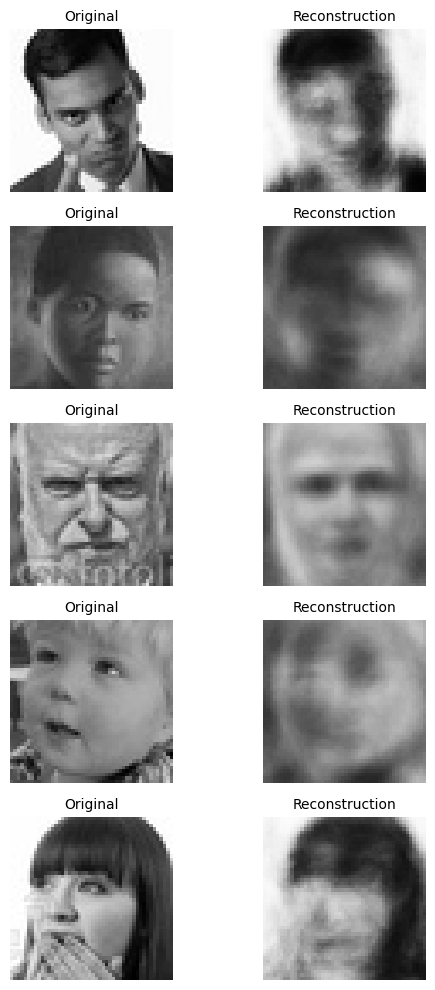

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# We assume `model` and `test_loader` already exist from previous sections.
model.eval()

# Get a single batch from the test loader
xb = next(iter(test_loader))[0].to(next(model.parameters()).device)

with torch.no_grad():
    xhat = model(xb)

# Move to CPU and convert to numpy for plotting
orig = xb.detach().cpu().numpy()      # (N, 1, 48, 48)
reco = xhat.detach().cpu().numpy()    # (N, 1, 48, 48)

# Select up to 5 examples to display
n_rows = min(5, orig.shape[0])

fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2*n_rows))
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)  # ensure 2D indexing

for i in range(n_rows):
    # Original
    axes[i, 0].imshow(orig[i, 0, :, :], cmap="gray", vmin=0.0, vmax=1.0)
    axes[i, 0].set_title("Original", fontsize=10)
    axes[i, 0].axis("off")

    # Reconstruction
    axes[i, 1].imshow(reco[i, 0, :, :], cmap="gray", vmin=0.0, vmax=1.0)
    axes[i, 1].set_title("Reconstruction", fontsize=10)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

**What We Should Notice**

- Reconstructions often appear slightly smoother than the originals. This is normal: by compressing the image into a low-dimensional latent vector, the model tends to remove high-frequency details (fine texture and noise).

- The model usually preserves global structure: head contour, eye placement, brow shape, and mouth curve. These structures carry a lot of the emotional signal.

- If we see over-smoothing or missing details around the eyes or mouth, that suggests the latent dimension or the training budget might be too small. Increasing the latent size or training for more epochs can help.

> The key point is that our autoencoder learns a compact representation that captures the essence of the face. Even without labels, it retains features that are important for expression, which we will explore further when we analyze the latent space.

---

### **8. Interpreting Latent Representations**

So far, we focused on **reconstruction quality** — what comes out of the decoder.  
But equally important is what happens **inside the model**: the **latent space** learned by the encoder.

This latent space is a **compressed (128-D)** representation of each face.  
Even without labels, the autoencoder tries to store the **most informative visual features** needed to reconstruct the image.

**What kind of features could the latent space encode?**
- Face symmetry or orientation  
- Lighting and shading  
- Shape of mouth, eyes, eyebrows  
- Subtle emotional expressions  

> The fascinating part: the autoencoder discovers these features **without any emotion labels!**


**Can Emotions Be Separated in Latent Space?**

To explore this, we will project the 128-D latent vectors into **2D** using:

- **PCA** – linear projection (captures global variance)
- **t-SNE** – nonlinear projection (captures local structure)

Rather than all 7 emotions at once (which can be visually noisy),  
we will focus on **pairs of emotions** where we might expect visual differences.

We will examine:

✅ **Happy vs Surprise** (both positive, but different expressions)  
✅ **Happy vs Disgust** (emotionally and visually contrasting)


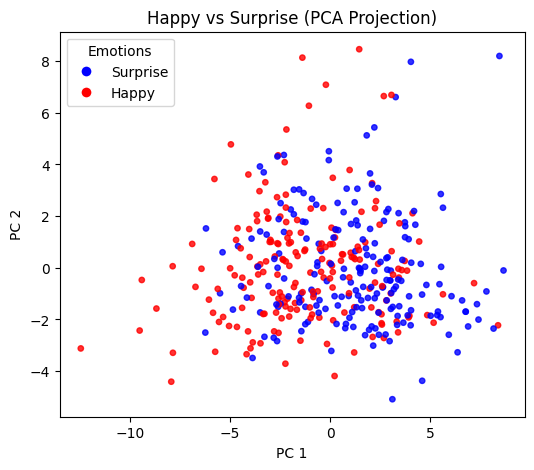

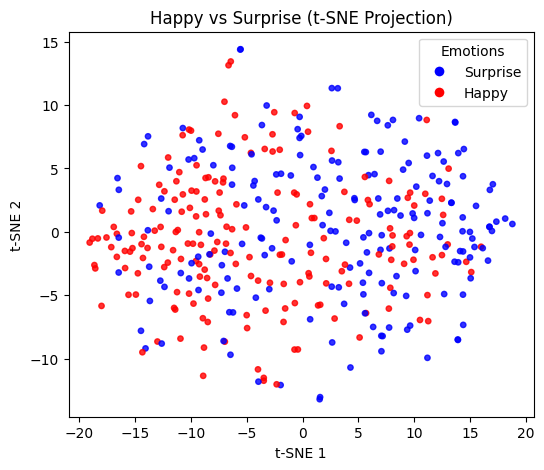

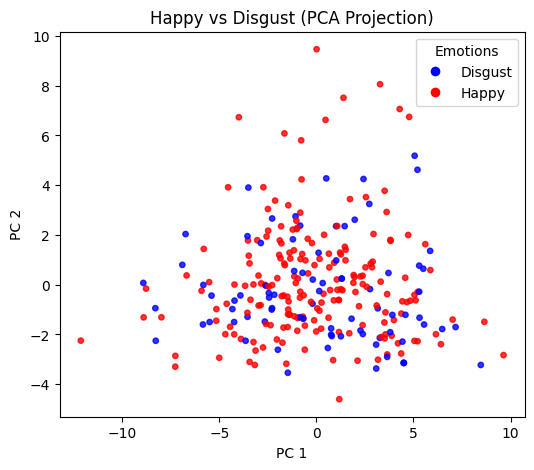

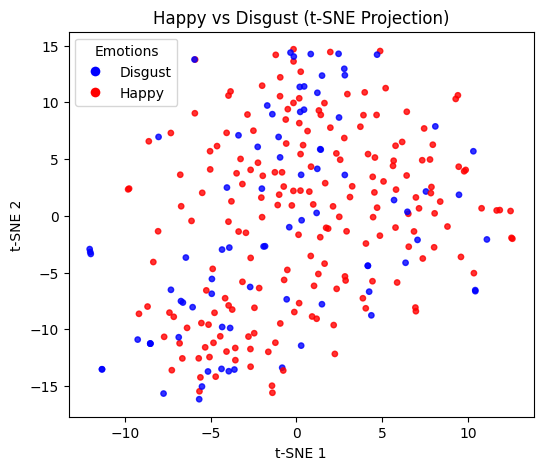

In [46]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

model.eval()
latents, labels = [], []

with torch.no_grad():
    for xb, in test_loader:
        xb = xb.to(next(model.parameters()).device)
        n = xb.size(0)
        z = model.encoder(xb.view(n, -1))  # (N, 128)
        latents.append(z.cpu().numpy())

latents = np.concatenate(latents, axis=0)
labels = y_test  # from earlier split

# Emotion indices
HAPPY = 3
SURPRISE = 5
DISGUST = 1

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

pairs = [
    (HAPPY, SURPRISE, f"Happy vs Surprise"),
    (HAPPY, DISGUST, f"Happy vs Disgust"),
]

for a, b, title in pairs:
    # Filter the two classes
    mask = np.isin(labels, [a, b])
    L = latents[mask]
    y_pair = labels[mask]

    # Remap to 0 and 1 for consistent coloring
    y_binary = (y_pair == a).astype(int)  # 1 = Happy, 0 = Other emotion

    # Standardize latent vectors
    L_std = StandardScaler().fit_transform(L)

    # ----- PCA (2D) -----
    L_pca = PCA(n_components=2, random_state=42).fit_transform(L_std)

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(L_pca[:,0], L_pca[:,1],
                          c=y_binary, cmap="bwr", s=15, alpha=0.8)

    # Legend
    labels_legend = [emotion_names[a], emotion_names[b]]
    handles = [
        plt.Line2D([], [], marker="o", color="w",
                   markerfacecolor="blue", markersize=8, label=labels_legend[1]),  # 0 class
        plt.Line2D([], [], marker="o", color="w",
                   markerfacecolor="red", markersize=8, label=labels_legend[0])   # 1 class (Happy)
    ]
    plt.legend(handles=handles, title="Emotions", loc="best")

    plt.title(f"{title} (PCA Projection)")
    plt.xlabel("PC 1"); plt.ylabel("PC 2")
    plt.show()

    # ----- t-SNE (with PCA-30 init) -----
    L_pca_30 = PCA(n_components=30, random_state=42).fit_transform(L_std)
    L_tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42
    ).fit_transform(L_pca_30)

    plt.figure(figsize=(6,5))
    plt.scatter(L_tsne[:,0], L_tsne[:,1],
                c=y_binary, cmap="bwr", s=15, alpha=0.8)

    # Legend again
    plt.legend(handles=handles, title="Emotions", loc="best")

    plt.title(f"{title} (t-SNE Projection)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.show()


**What Do These Plots Tell Us?**

- If **Happy and Surprise** tend to form loose groups, it suggests the model captures subtle expression differences (e.g., mouth open, eyes widened).
- If **Happy and Disgust** separate more clearly, specially in t-SNE, it shows the model encodes contrasting facial features (smile vs nose scrunch).

Even if separation is not perfect:
✅ It still reveals that **unsupervised learning captures emotional structure** to some extent.  
✅ A simple autoencoder is already learning meaningful internal representations!

**Why Latent Spaces Matter**

Latent representations are the backbone of modern generative models:

- **VAEs** – add probabilistic structure to latent space ⇒ can **sample new data**
- **GANs** – generate realistic images through adversarial training
- **Diffusion / Transformers** – extend latent learning to high-resolution images and language

Our autoencoder is the **first step**:  
it learns to **compress** images and **reconstruct** them from a meaningful internal code.

> In the next notebook, we will build **Variational Autoencoders (VAEs)** and explore how adding structure to the latent space enables **generation** of new faces — not just reconstruction.

---


### **9. Reflection & Key Takeaways**

We have now completed our first exploration of **generative modeling** through the lens of an **autoencoder**.  
In this notebook, we shifted our focus from *predicting labels* to *understanding structure* — a subtle but powerful change in perspective that sets the stage for everything we’ll do next.

**How an Autoencoder Differs from a Classifier**

A **classifier** learns to map input $x$ to a target label $y$. Its goal is *discriminative*: to separate categories based on features.  
An **autoencoder**, in contrast, learns to map input $x$ back to itself $\hat{x}$. Its goal is *reconstructive*: to represent and reproduce the essential characteristics of the data.

| Model Type | Goal | Learning Signal | Output | Example |
|-------------|------|-----------------|---------|----------|
| **Classifier** | Distinguish categories | External labels (supervised) | Class probabilities | Emotion recognition |
| **Autoencoder** | Capture data structure | Self-supervision (no labels) | Reconstructed image | Face reconstruction |

> The autoencoder learns from the *data itself*. Instead of answering “what emotion is this face?”, it answers “what information is needed to recreate this face?”

**What the Model Learns Without Labels**

Even without any explicit labels, the model discovers internal patterns that define the structure of facial images:

- **Geometric features** such as eye placement, mouth shape, and head contour  
- **Symmetry and orientation**, crucial for reconstructing coherent faces  
- **Expression cues**, like smiles or frowns, that persist in the latent space  

This learning happens *emergently* — it arises from the reconstruction objective rather than from human supervision.

> By minimizing the reconstruction error, the network naturally learns to focus on features that are both stable and meaningful for reconstruction — a form of unsupervised *feature discovery*.

**Reconstruction as Understanding**

Reconstruction isn’t just a mechanical reproduction process.  
When the model can successfully reconstruct faces across diverse emotions, it indicates that it has developed an **internal understanding** of how facial features vary and combine.

In essence, reconstruction reflects *comprehension through compression*:
> The encoder learns what information can be safely discarded,  
> and the decoder learns what must be retained to recover identity and expression.

This is what makes autoencoders a bridge between **representation learning** and **generative modeling**.

**Looking Ahead**

In the next few notebooks, we will build upon this foundation to explore deeper generative models that introduce additional structure to the latent space:

- **Variational Autoencoders (VAEs):** introduce probabilistic latent variables, allowing us to *sample* new data rather than just reconstruct existing ones.  
- **Generative Adversarial Networks (GANs):** pit two networks against each other — a generator and a discriminator — to produce highly realistic synthetic images.

These models expand the idea we started here: that by learning to **encode and decode**, neural networks can **understand and create**.

> **In summary:**  
> This notebook introduced us to the world of *representation and reconstruction*.  
> We saw how an autoencoder compresses images into meaningful latent codes, and how decoding them back reveals what the model finds essential.  
> From here, we move toward models that not only reconstruct — but *generate*.

---

### **10. Optional Extension Ideas**

For those of us who wish to go a step further, here are a few powerful directions to explore beyond the basic fully connected autoencoder.

These extensions not only make the model more expressive but also bridge the gap toward modern **deep generative architectures**.

**Adding Convolutional Layers for Spatial Feature Learning**

Our current autoencoder treats each 48×48 image as a flat vector of 2,304 pixels, ignoring the spatial relationships between them.  
By introducing **convolutional layers**, we can allow the model to directly exploit 2D structure — edges, contours, and local patterns — that are critical in face representation.

> A **Convolutional Autoencoder (ConvAE)** replaces fully connected layers with `Conv2d` and `ConvTranspose2d`, learning spatially-aware filters.  
> Such a model typically produces **sharper** and more **structurally coherent** reconstructions, even with fewer parameters.




**Introducing Denoising Autoencoders**

Another fascinating variant is the Denoising Autoencoder (DAE).
Instead of reconstructing a clean input directly, we deliberately corrupt the input (for example, by adding noise or masking pixels) and train the model to reconstruct the original, noise-free version.

> This encourages the model to learn robust, noise-invariant representations, and it becomes better at capturing the underlying structure of the data rather than memorizing surface patterns.

Conceptually:

$$
x' = x + \text{noise}, \quad \hat{x} = f_\theta(x'), \quad L = \|x - \hat{x}\|^2
$$

This simple modification forms the basis for many later models that emphasize **stability** and **generalization**, including *denoising diffusion models* — one of the most powerful generative paradigms today.

> These optional extensions are **not required for this notebook**, but they open the door to richer forms of **representation learning**.

> By experimenting with convolutional layers, latent traversals, denoising objectives we start to glimpse the **flexibility and creativity** that generative models can achieve — paving our way toward **VAEs, GANs**, and beyond.
